In [25]:
import pandas as pd
from citipy import citipy
import numpy as np
import csv
from datetime import datetime as dt, timedelta, time, date
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import gmaps 
from config import gkey

#import data
weather = pd.read_json("ow.json") #1/1/2013-1/1/2020 hourly weather data
crime = pd.read_csv("crime.csv")

In [26]:
drop_list = ['GEO_X', 'GEO_Y', 'DISTRICT_ID', 
             'REPORTED_DATE', 'LAST_OCCURRENCE_DATE',
            'INCIDENT_ID', 'OFFENSE_ID', 'OFFENSE_CODE_EXTENSION']
crime.drop(columns=drop_list, inplace=True)

In [27]:
crime = crime.rename(columns = {'OFFENSE_CODE':'Code', 
                               'OFFENSE_TYPE_ID':'Offense_Type', 
                               'INCIDENT_ADDRESS':'Address', 
                               'GEO_LON':'Lon',
                               'GEO_LAT':'Lat', 
                               'PRECINCT_ID':'Precint', 
                               'NEIGHBORHOOD_ID':'Neighborhood'})

In [28]:
#expand list from columns into new databases
weather_temp = (json_normalize(weather['main']))
weather_wind = json_normalize(weather['wind'])
weather_clouds = json_normalize(weather['clouds'])

In [29]:
#create new columns for desired fields from expanded list
weather_temp.head()
weather['Temp'] = weather_temp['temp']
weather['Temp Max'] = weather_temp['temp_max']
weather['Wind'] = weather_wind.speed
weather['Clouds'] = weather_clouds
#split date iso into columns, then delete unwanted columns 
weather[['Date','Hour', 'Trash', 'Trash2']] = weather.dt_iso.str.split(expand=True)
columns = ['wind', 'clouds', 'weather','main', 'timezone', 'snow', 'rain', 'dt', 'Trash', 'Trash2', 'dt_iso', 'lat', 'lon']
weather.drop(columns=columns, inplace=True)

In [30]:
crime['Date'] = pd.to_datetime(crime['FIRST_OCCURRENCE_DATE'])

In [31]:
crime.head()
crime.drop(columns=['FIRST_OCCURRENCE_DATE'], inplace=True)

In [32]:
# df = pd.DataFrame([{'old_column':pd.Timestamp('2015-07-18 13:53:33.280')}])
crime['Date'] = crime['Date'].dt.round('60min')

In [33]:
weather.head()
weather = weather.rename(columns = {'Date & Time':'Date'})

In [34]:
# remove incorrect lat longs skewing data
crime = crime[crime["Lon"] <= -104.2]
crime = crime[crime["Lon"] >= -105.5]
crime = crime[crime["Lat"] >= 39.5]
crime = crime[crime["Lat"] <= 40.0]

crime_weather = pd.merge(crime, weather, on='Date', how='left')


ValueError: You are trying to merge on datetime64[ns] and object columns. If you wish to proceed you should use pd.concat

In [ ]:
crime_weather.to_csv('crime_weather.csv')

# What CRIME occurs the most in cold, warm, and hot temperatures?

In [35]:
cw_path = pd.read_csv('crime_weather.csv')
cw_orig = pd.DataFrame(cw_path)
crime_weather = pd.read_csv('crime_weather.csv')

In [36]:
# bin by temperature ranges
bins = [-50, 32, 50, 70, 120]
temp_names = ["Freezing","Cold","Warm","Hot"]
cw_orig["Temp Range"] = pd.cut(cw_orig['Temp'], bins, labels=temp_names)
cw_orig.head()

,Unnamed: 0,Code,Offense_Type,OFFENSE_CATEGORY_ID,Address,Lon,Lat,Precint,Neighborhood,IS_CRIME,IS_TRAFFIC,Date,city_name,Temp,Temp Max,Wind,Clouds,Temp Range
0,1,2399,theft-other,Burglary/Theft,NaN,-104.781434,39.785649,522,gateway-green-valley-ranch,1,0,2017-10-11 12:00:00,Denver,40.77,41.00,4.70,1.0,Cold
1,2,2305,theft-items-from-vehicle,Burglary/Theft,2932 S JOSEPHINE ST,-104.957381,39.663490,314,wellshire,1,0,2016-03-04 20:00:00,Denver,55.90,57.20,11.41,75.0,Warm
2,3,2399,theft-other,Burglary/Theft,705 S COLORADO BLVD,-104.941440,39.702698,312,belcaro,1,0,2018-01-30 19:00:00,Denver,57.88,62.60,19.69,75.0,Warm
3,4,2303,theft-shoplift,Burglary/Theft,2810 E 1ST AVE,-104.955370,39.717107,311,cherry-creek,1,0,2017-06-22 21:00:00,Denver,79.86,84.38,19.69,75.0,Hot
4,6,2304,theft-parts-from-vehicle,Burglary/Theft,995 N FEDERAL BLVD,-105.025543,39.732790,122,villa-park,1,0,2017-06-01 12:00:00,Denver,51.96,53.60,5.82,40.0,Warm


In [37]:
# filter out traffic violations
iscrime_df = cw_orig[cw_orig['IS_CRIME']==1]
iscrime_df.head()

,Unnamed: 0,Code,Offense_Type,OFFENSE_CATEGORY_ID,Address,Lon,Lat,Precint,Neighborhood,IS_CRIME,IS_TRAFFIC,Date,city_name,Temp,Temp Max,Wind,Clouds,Temp Range
0,1,2399,theft-other,Burglary/Theft,NaN,-104.781434,39.785649,522,gateway-green-valley-ranch,1,0,2017-10-11 12:00:00,Denver,40.77,41.00,4.70,1.0,Cold
1,2,2305,theft-items-from-vehicle,Burglary/Theft,2932 S JOSEPHINE ST,-104.957381,39.663490,314,wellshire,1,0,2016-03-04 20:00:00,Denver,55.90,57.20,11.41,75.0,Warm
2,3,2399,theft-other,Burglary/Theft,705 S COLORADO BLVD,-104.941440,39.702698,312,belcaro,1,0,2018-01-30 19:00:00,Denver,57.88,62.60,19.69,75.0,Warm
3,4,2303,theft-shoplift,Burglary/Theft,2810 E 1ST AVE,-104.955370,39.717107,311,cherry-creek,1,0,2017-06-22 21:00:00,Denver,79.86,84.38,19.69,75.0,Hot
4,6,2304,theft-parts-from-vehicle,Burglary/Theft,995 N FEDERAL BLVD,-105.025543,39.732790,122,villa-park,1,0,2017-06-01 12:00:00,Denver,51.96,53.60,5.82,40.0,Warm


In [38]:
# crime vs temp table 
crime_temp = iscrime_df[['OFFENSE_CATEGORY_ID','IS_CRIME','Temp Range']]
pivot_df = crime_temp.pivot_table(crime_temp, index='Temp Range', columns='OFFENSE_CATEGORY_ID', 
                                  aggfunc='count')
pivot_df

IS_CRIME                       \
OFFENSE_CATEGORY_ID Aggravated Assault Arson Burglary/Theft   
Temp Range                                                    
Freezing                          1361    57          19517   
Cold                              2771   155          37467   
Warm                              3831   184          47563   
Hot                               3236   147          31363   

                                                                \
OFFENSE_CATEGORY_ID Crimes Against Persons Drug/Alcohol Murder   
Temp Range                                                       
Freezing                              3035         3821     31   
Cold                                  6199         8207     61   
Warm                                  7654        10582    113   
Hot                                   5655         6506     90   

                                                        
OFFENSE_CATEGORY_ID Public Disorder White Collar Crime  
Temp Range                                              
Freezing                       6107               1172  
Cold                          12630               2014  
Warm                          16246               2238  
Hot                           11068                931

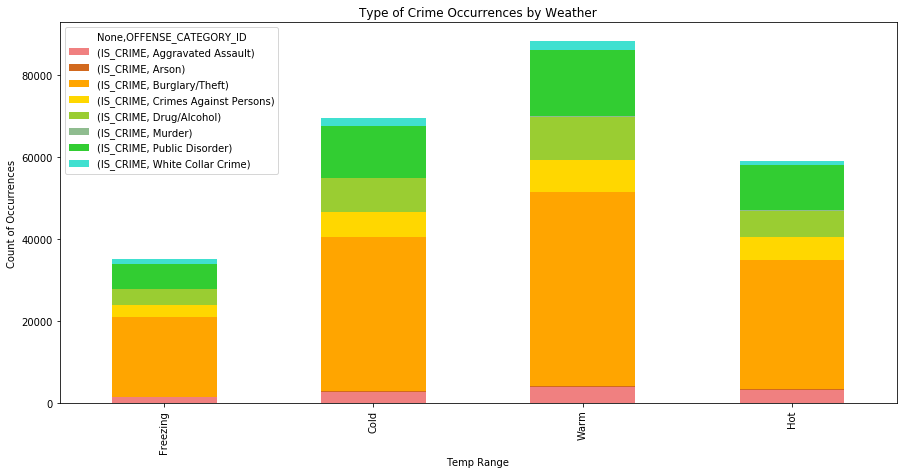

In [39]:
# stacked bar chart
colors = ['lightcoral','chocolate','orange','gold','yellowgreen','darkseagreen','limegreen','turquoise','teal','skyblue',
          'slategrey','mediumpurple','hotpink']
pivot_df.plot.bar(stacked=True, color=colors, figsize=(15,7))
plt.ylabel("Count of Occurrences")
plt.title("Type of Crime Occurrences by Weather")
plt.show()

# What TRAFFIC VIOL occurs the most in cold, warm, and hot temperatures?

In [40]:
# filter out crime violations
istraffic_df = cw_orig[cw_orig['IS_TRAFFIC']==1]
istraffic_df.head()

,Unnamed: 0,Code,Offense_Type,OFFENSE_CATEGORY_ID,Address,Lon,Lat,Precint,Neighborhood,IS_CRIME,IS_TRAFFIC,Date,city_name,Temp,Temp Max,Wind,Clouds,Temp Range
5,8,5401,traffic-accident-hit-and-run,Traffic Accident,W 13TH AVE / N CHEROKEE ST,-104.991650,39.736863,611,civic-center,0,1,2018-01-30 09:00:00,Denver,44.94,53.60,12.75,75.0,Cold
15,19,5441,traffic-accident,Traffic Accident,N HAVANA ST / I70 HWYWB,-104.865745,39.775833,511,stapleton,0,1,2018-01-30 13:00:00,Denver,40.77,41.00,3.36,1.0,Cold
16,21,5441,traffic-accident,Traffic Accident,E LOWRY BLVD / N YOSEMITE WAY,-104.883908,39.723506,321,lowry-field,0,1,2018-01-29 14:00:00,Denver,28.92,30.20,9.17,40.0,Freezing
17,22,5401,traffic-accident-hit-and-run,Traffic Accident,29TH ST / WELTON ST,-104.975646,39.756668,211,five-points,0,1,2018-01-30 16:00:00,Denver,54.63,57.20,13.87,75.0,Warm
32,43,5441,traffic-accident,Traffic Accident,E 6TH AVE / N IVY LN,-104.920437,39.725338,321,hilltop,0,1,2018-01-30 17:00:00,Denver,51.85,51.98,16.11,75.0,Warm


In [41]:
# traffic violation vs temp table 
traffic_temp = istraffic_df[['OFFENSE_CATEGORY_ID','IS_TRAFFIC','Temp Range']]
traffic_pivot = traffic_temp.pivot_table(traffic_temp, index='Temp Range', columns='OFFENSE_CATEGORY_ID', 
                                  aggfunc='count')
# stacked bar chart
# traffic_pivot.plot.bar(stacked=True, color=colors, figsize=(15,7))
# plt.ylabel("Count of Violations")
# plt.title("Type of Traffic Violations by Weather")
# plt.show()

In [42]:
traffic_type = istraffic_df[istraffic_df['OFFENSE_CATEGORY_ID']=="traffic-accident"]
traffic_df = pd.DataFrame(traffic_type)
traffic_df['Offense_Type'].value_counts()

Series([], Name: Offense_Type, dtype: int64)

# Burglary Plot

In [43]:
burg = iscrime_df[iscrime_df['OFFENSE_CATEGORY_ID']=="burglary"]
burg_df = pd.DataFrame(burg)
burg_df['Offense_Type'].value_counts()

Series([], Name: Offense_Type, dtype: int64)

In [44]:
# Burglary
burg = iscrime_df[iscrime_df['OFFENSE_CATEGORY_ID']=="burglary"]
burg_df = pd.DataFrame(burg)
burg_df['Offense_Type'].value_counts()

Series([], Name: Offense_Type, dtype: int64)

In [45]:
# stacked Burglary
burg_plot = burg_df[['Offense_Type','IS_CRIME','Temp Range']]
burg_pivot = burg_plot.pivot_table(burg_plot, index='Temp Range', columns='Offense_Type', aggfunc='count')
burg_pivot.plot.bar(stacked=True, color=colors, figsize=(15,7))
plt.ylabel("Count of Occurrences")
plt.title("Type of Burglary Occurrences by Weather")
plt.show()

TypeError: no numeric data to plot

# Murder Plot

In [ ]:
murder = iscrime_df[iscrime_df['OFFENSE_CATEGORY_ID']=="murder"]
murder_df = pd.DataFrame(murder)
murder_df['Offense_Type'].value_counts()

In [ ]:
# stacked Drug-Alcohol
murder_plot = murder_df[['Offense_Type','IS_CRIME','Temp Range']]
murder_pivot = murder_plot.pivot_table(murder_plot, index='Temp Range', columns='Offense_Type', aggfunc='count')
murder_pivot.plot.bar(stacked=True, color=colors, figsize=(15,7))
plt.ylabel("Count of Occurrences")
plt.title("Type of Drug/Alcohol Occurrences by Weather")
plt.show()

# Days per Weather 

In [ ]:
import datetime
weather_days = cw_orig[['Date','Temp Range']]
weather_daydf = pd.DataFrame(weather_days)
weather_daydf['Dates'] = pd.to_datetime(weather_daydf['Date'],format='%Y%m%d')
# weather_daydf['DateTime'] = pd.to_datetime(weather_daydf['Date'])
# weather_daydf['DateOnly'] = datetime.date(weather_daydf['DateTime'],format='%Y%m%d',errors='coerce')
#weather_days['Date Normalized'] = weather_days['Date'].dt.normalize(errors='coerce')

In [47]:
#seperate data into crime dataframe and traffic datafram
is_crime = crime_weather.loc[crime_weather['IS_CRIME'] == 1]
is_traffic = crime_weather.loc[crime_weather['IS_TRAFFIC'] == 1]

#drop dates from weather for before earliest crime data entry
#use this dataframe to standardize data
weather = weather.loc[weather['Date'] > '2015-01-02 00:00:00']

In [48]:
#bin crime, traffic and weather data 
bins = [-10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
groups = ['-10-0', '0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100', '100-110']
is_crime['Temp Range'] = pd.cut(is_crime["Temp"], bins, labels=groups)
is_traffic['Temp Range'] = pd.cut(is_traffic["Temp"], bins, labels=groups)
weather['Temp Range'] = pd.cut(weather["Temp"].round(), bins, labels=groups)

#set new index and drop na
is_crime.set_index('Temp Range', inplace=True)
is_traffic.set_index('Temp Range', inplace=True)
weather.set_index('Temp Range', inplace=True)
weather.sort_index(inplace=True)
weather.dropna(inplace=True)

C:\Users\Deepak\Anaconda\envs\PythonData\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Deepak\Anaconda\envs\PythonData\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Deepak\Anaconda\envs\PythonData\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [49]:
#groupby Neighborhood and set weight for heatmap = count of crimes within neighboorhood
groupn_mean_df = crime_weather.groupby("Neighborhood").mean()
count  = crime_weather.groupby("Neighborhood").count()['IS_CRIME'].astype(float)

#set locations equal to neighborhood lat and lon
locations = groupn_mean_df[["Lat", "Lon"]].astype(float)

In [50]:
#map crime in denver
gmaps.configure(api_key=gkey)
fig = gmaps.figure()
heat_layer = gmaps.heatmap_layer(locations, weights=count, max_intensity=10000,
                                 point_radius = 15)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [51]:
##standardize data 

Ctemp_Plot = is_crime.groupby('Temp Range').count()
Ttemp_Plot = is_traffic.groupby('Temp Range').count()
weather_Count = weather.groupby('Temp Range').count()
#Ctemp_Plot = Ctemp_Plot.drop('100-110')
#Ttemp_Plot = Ttemp_Plot.drop('100-110')
Cstandardize = Ctemp_Plot['Code'] / weather_Count['Temp']
Tstandardize = Ttemp_Plot['Code'] / weather_Count['Temp']

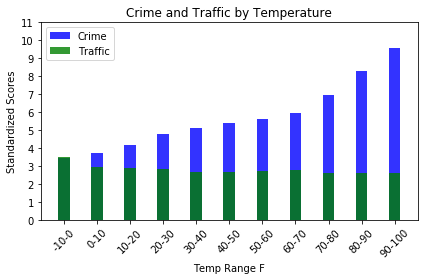

<Figure size 432x288 with 0 Axes>

In [52]:
#create bar chart containing crime and traffic by temp
fig, ax = plt.subplots()
bar_width = 0.35
opacity = 0.8

crime = plt.bar(Cstandardize.index, Cstandardize, bar_width,
alpha=opacity,
color='b',
label='Crime')

traffic = plt.bar(Tstandardize.index, Tstandardize, bar_width,
alpha=opacity,
color='g',
label='Traffic')

plt.xlabel('Temp Range F')
plt.ylabel('Standardized Scores')
plt.title('Crime and Traffic by Temperature')
plt.xticks(rotation = '45')
plt.yticks(range(0,12))
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

#save to png
plt.savefig("crime and traffic temp.png")

In [53]:
#create bins for Wind Ranges for Weather, Crime and traffic databases
bins = [0, 10, 20, 30, 40, 51]
groups = ['0-10', '10-20', '20-30', '30-40', '40-50']
is_crime['Wind Range'] = pd.cut(is_crime["Wind"].round(), bins, labels=groups)

bins = [0, 10, 20, 30, 40, 51]
groups = ['0-10', '10-20', '20-30', '30-40', '40-50']
is_traffic['Wind Range'] = pd.cut(is_traffic["Wind"].round(), bins, labels=groups)

bins = [0, 10, 20, 30, 40, 51]
groups = ['0-10', '10-20', '20-30', '30-40', '40-50']
weather['Wind Range'] = pd.cut(weather["Wind"].round(), bins, labels=groups)


C:\Users\Deepak\Anaconda\envs\PythonData\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Deepak\Anaconda\envs\PythonData\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Deepak\Anaconda\envs\PythonData\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [54]:
#set new index to Wind Range
is_crime = is_crime.set_index('Wind Range')
weather = weather.set_index('Wind Range')
is_traffic = is_traffic.set_index('Wind Range')

In [55]:
#set variables and standardize data
Cwind_Count = is_crime.groupby('Wind Range').count()
Wwind_Count = weather.groupby('Wind Range').count()
Cwind_stand = Cwind_Count['Temp'] / Wwind_Count['Temp']

Twind_Count = is_traffic.groupby('Wind Range').count()
Twind_stand = Twind_Count['Temp'] / Wwind_Count['Temp']

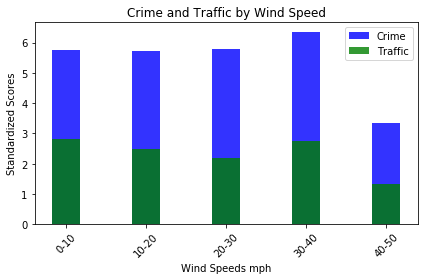

<Figure size 432x288 with 0 Axes>

In [56]:
#bar chart crime and traffic by wind
fig, ax = plt.subplots()
bar_width = 0.35
opacity = 0.8

crime = plt.bar(Cwind_stand.index, Cwind_stand, bar_width,
alpha=opacity,
color='b',
label='Crime')

traffic = plt.bar(Twind_stand.index, Twind_stand, bar_width,
alpha=opacity,
color='g',
label='Traffic')

plt.xlabel('Wind Speeds mph')
plt.ylabel('Standardized Scores')
plt.title('Crime and Traffic by Wind Speed')
plt.xticks(rotation = '45')
plt.legend()

plt.tight_layout()
plt.show()

#save fig to png
plt.savefig("crime and traffic wind.png")